<a href="https://colab.research.google.com/github/adamsohjunior/SC3000-Artificial-Intelligence-/blob/main/SC3000_SCSX_Cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial and Sample Code for Balancing a Pole on a Cart

## Installing dependencies:

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 35.6 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.6 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.1.0
    Uninstalling setuptools-75.1.0:
      Successfully uninstalled setuptools-75.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.

^C


In [ ]:
!apt-get update
!apt-get install -y python3-pygame

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

## Importing dependencies and define helper functions

In [ ]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

Set up extra dependencies to be used later in the code implementation below.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

## Tutorial: Loading CartPole environment

In [ ]:
env = gym.make("CartPole-v1")

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [ ]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [ ]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [ ]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: [-0.03485824 -0.03901913 -0.04709134 -0.00538734]


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [ ]:
observation, reward, done, info = env.step(0)
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [-0.03563862 -0.2334352  -0.04719909  0.27207375]
Reward for this step: 1.0
Is this round done? False


/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [ ]:
observation = env.reset()
cumulative_reward = 0
done = False
while not done:
    observation, reward, done, info = env.step(0)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 9.0


## Task 1: Development of an RL agent

An example of a naive agent is given below, which randomly chooses an action regardless of the observation:

In [ ]:
def rand_policy_agent(observation):
    return random.randint(0, 1)

For the Reinforcement Learning (RL) agent, our team decides to go with **Deep Q-Network (DQN)** to balance the pole on the cart.

1. First, let us define the *DQN Model*.
*   We define a contructor method to create two hidden layers (fc1 and fc2) with 256 neurons each, followed by one output layer with action_size neurons.
*   We create a forward method to define how data flows through the network.
*   We applied *Rectified Linear Unit (ReLU)* activation function to introduce non-linearity, allowing the network to learn complex patterns.






In [ ]:
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 256)  # First fully coonected layer
        self.fc2 = nn.Linear(256, 256)          # Second fully connected layer
        self.fc3 = nn.Linear(256, action_size)    # Output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x)) #
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

2. Next, we also define the Experience Replay Buffer. This will allow the agent to sample from these experiences randomly during training. This also help to break the correlation between consecutive experiences and stablilizes training.

In [ ]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)  #automatically remove oldest experience if buffer is full

    def push(self, state, action, reward, next_state, done):   #Add new experience tuple into the buffer
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size): #randomly sample a batch of experiences from the buffer
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

3. Next, we will set up the hyperparameters and intializes the key components of the DQN algorithm.

In [ ]:
state_size = env.observation_space.shape[0] #size of state space, i.e. 4
print(state_size)
action_size = env.action_space.n  #number of possible actions, i.e. 2 (left and right)
print(action_size)
batch_size = 132        # The number of experiences sampled from the replay buffer for each training step
gamma = 0.99              # Discount factor for future reward
epsilon_start = 1.0       # Initial exploration rate
epsilon_end = 0.01        # Minimum exploration rate
epsilon_decay = 0.995     # Control how quickly exploration decreases
target_update = 10        # Frequency of updating the target network
learning_rate = 0.00025    # Lower learning rate for stability

policy_net = DQN(state_size, action_size)
target_net = DQN(state_size, action_size)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
buffer = ReplayBuffer(50000)    # Replay buffer to store experiences (capacity = 50,000)
epsilon = epsilon_start         # Initialize exploration rate to 1.0 (100% exploration)

4
2


4. We will load the saved model parameters (weights) if they exist.

  Else, we would need to train the model first. (refer to Training Loop)

In [ ]:
# Load the saved model weights (if they exist)
try:
    policy_net.load_state_dict(torch.load("cartpole_dqn_final.pth"))
    print("Loaded pre-trained model!")
except FileNotFoundError:
    print("No pre-trained model found. Training a new model.")

Loaded pre-trained model!


<ipython-input-77-2116596d19b0>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy_net.load_state_dict(torch.load("cartpole_dqn_final.pth"))


5. **Training Loop:** Once we finished the setup, we can train the agent now by interacting with the environment, collect experiences and update the neural network to improve its policy.

In [ ]:
episode_rewards = []          # Store the total reward for each episode
best_reward = -float('inf')  # Tracks the best reward achieved so far

for episode in range(1000):   # Train for 100 episodes until the agent solves the environment
    state = env.reset()
    total_reward = 0
    while True:
        # Epsilon-greedy action
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                q_values = policy_net(torch.FloatTensor(state))
                action = q_values.argmax().item()

        # Take action
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        buffer.push(state, action, reward, next_state, done)

        # Train with Double DQN
        if len(buffer) >= batch_size:
            transitions = buffer.sample(batch_size)
            states, actions, rewards, next_states, dones = zip(*transitions)

            states = torch.FloatTensor(states)
            next_states = torch.FloatTensor(next_states)

            # Double DQN: Use policy net for action selection, target net for evaluation
            current_q = policy_net(states).gather(1, torch.LongTensor(actions).unsqueeze(1))
            next_actions = policy_net(next_states).argmax(1, keepdim=True)
            next_q = target_net(next_states).gather(1, next_actions).detach()

            target_q = torch.FloatTensor(rewards).unsqueeze(1) + gamma * next_q * (1 - torch.FloatTensor(dones).unsqueeze(1))

            # Huber loss for stability
            loss = nn.SmoothL1Loss()(current_q, target_q)

            optimizer.zero_grad()
            loss.backward()
            # Gradient clipping to prevent explosions
            torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 1.0)
            optimizer.step()

        state = next_state
        if done:
            break

    # Decay epsilon and update target network
    epsilon = max(epsilon_end, epsilon * epsilon_decay)
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

    episode_rewards.append(total_reward)
    print(f"Episode {episode}, Reward: {total_reward}, Epsilon: {epsilon:.2f}")

    # Early stopping if agent solves the environment
    if total_reward >= 500:
        print("Early stopping: Agent solved the environment!")
        break

# Save the trained policy network
torch.save(policy_net.state_dict(), "cartpole_dqn_final.pth")

Episode 0, Reward: 28.0, Epsilon: 0.99
Episode 1, Reward: 11.0, Epsilon: 0.99
Episode 2, Reward: 36.0, Epsilon: 0.99
Episode 3, Reward: 38.0, Epsilon: 0.98
Episode 4, Reward: 15.0, Epsilon: 0.98
Episode 5, Reward: 11.0, Epsilon: 0.97
Episode 6, Reward: 19.0, Epsilon: 0.97
Episode 7, Reward: 16.0, Epsilon: 0.96
Episode 8, Reward: 13.0, Epsilon: 0.96
Episode 9, Reward: 18.0, Epsilon: 0.95
Episode 10, Reward: 12.0, Epsilon: 0.95
Episode 11, Reward: 27.0, Epsilon: 0.94
Episode 12, Reward: 29.0, Epsilon: 0.94
Episode 13, Reward: 28.0, Epsilon: 0.93
Episode 14, Reward: 13.0, Epsilon: 0.93
Episode 15, Reward: 14.0, Epsilon: 0.92
Episode 16, Reward: 15.0, Epsilon: 0.92
Episode 17, Reward: 15.0, Epsilon: 0.91
Episode 18, Reward: 39.0, Epsilon: 0.91
Episode 19, Reward: 17.0, Epsilon: 0.90
Episode 20, Reward: 15.0, Epsilon: 0.90
Episode 21, Reward: 24.0, Epsilon: 0.90
Episode 22, Reward: 42.0, Epsilon: 0.89
Episode 23, Reward: 23.0, Epsilon: 0.89
Episode 24, Reward: 14.0, Epsilon: 0.88
Episode 25

In [ ]:
from google.colab import files
files.download("cartpole_dqn_final.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

6. After training with the environment, we can demonstrate that the agent can take a state (observation) from the environment and output a valid action.

In [ ]:
# Load trained policy_net (after training)
state = env.reset()
with torch.no_grad():
    q_values = policy_net(torch.FloatTensor(state))
    action = q_values.argmax().item()
print("Observation:", state)
print("Chosen action:", action)

Observation: [ 0.0483996   0.03684551  0.00176658 -0.04430445]
Chosen action: 1


## Task 2: Demonstrate the effectiveness of the RL agent

Once the RL agent is ready, we run the agent against 100 episodes and track the cumulative reward for each episode.

Then, we plot the result to visualize the agent's performance over the 100 episodes.

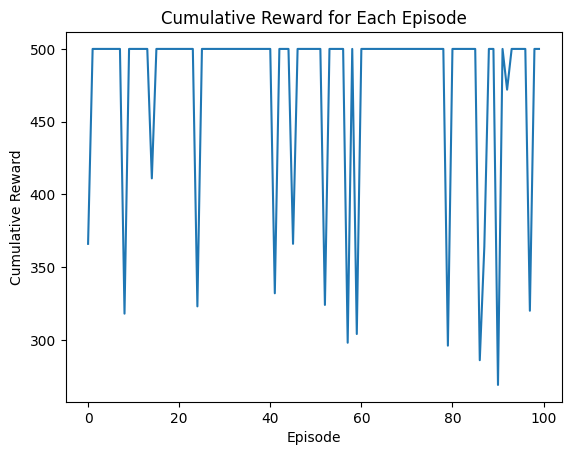

Average cumulative reward: 475.49
Is my agent good enough? True


In [ ]:
episode_results = []
for _ in range(100):
    state = env.reset()
    total_reward = 0
    while True:
        with torch.no_grad():
            q_values = policy_net(torch.FloatTensor(state))
            action = q_values.argmax().item()
        state, reward, done, _ = env.step(action)
        total_reward += reward
        if done:
            break
    episode_results.append(total_reward)

plt.plot(episode_results)
plt.title('Cumulative Reward for Each Episode')
plt.ylabel('Cumulative Reward')
plt.xlabel('Episode')
plt.show()

average_reward = np.mean(episode_results)
print(f"Average cumulative reward: {average_reward:.2f}")
print("Is my agent good enough?", average_reward > 195)

As stated above, we noticed the average cumulative reward is 338.17.

Since it is above 195, it indicates that our team's agent is good enough to solve the environment, that is to balance the pole on th cart.

## Task 3: Render one episode played by the agent

Finally, we plug our agent to the code below to obtain rendered result.

In [ ]:

policy_net.eval()  # Set network to evaluation mode

# Create environment with video recording
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()

while True:
    # Get action from trained agent
    with torch.no_grad():
        q_values = policy_net(torch.FloatTensor(observation))
        action = q_values.argmax().item()

    # Take the chosen action
    observation, reward, done, info = env.step(action)

    if done:
        break

env.close()
show_video()

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
